In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.activations import relu
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import layers as Layers
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})
tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


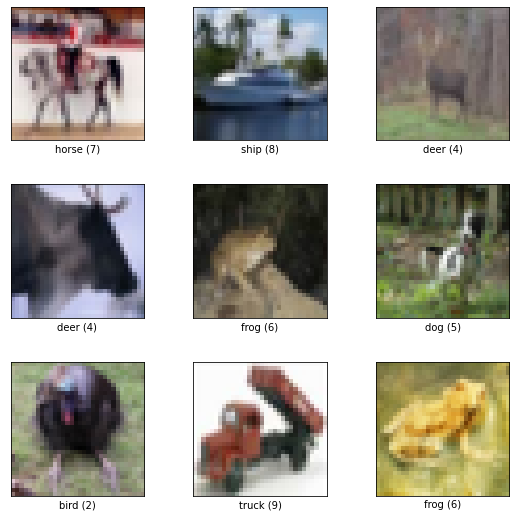

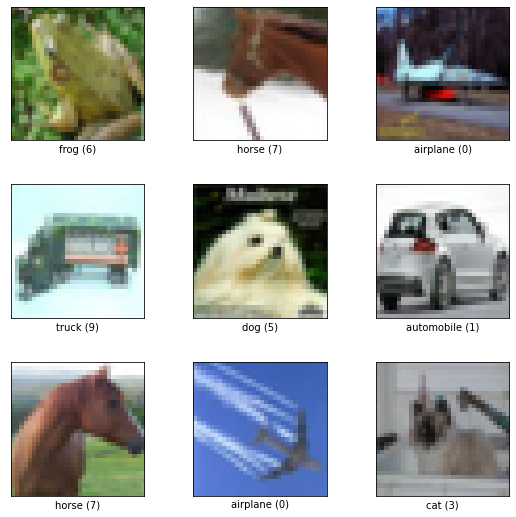

In [2]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

ds_info.features["label"].num_classes
ds_info.features["label"].names
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

In [3]:
# def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False,is_plain = False):
#     # 입력 레이어
#     x = input_layer
    
#     # resnet34:
#     if not is_50:
#     # CNN 레이어
#         for cnn_num in range(num_cnn):
#             identity = x
#             x = keras.layers.Conv2D(
#                 filters=channel,
#                 kernel_size=(3,3),
#                 activation=None,
#                 kernel_initializer='he_normal',
#                 padding='same',
#                 name=f'block{block_num}_conv{cnn_num}'
#             )(x)
#             x = keras.layers.BatchNormalization()(x)
#             x = keras.activations.relu(x)
#             x = keras.layers.Conv2D(
#                 filters=channel,
#                 kernel_size=(3,3),
#                 activation=None,
#                 kernel_initializer='he_normal',
#                 padding='same',
                
#             )(x)
#             x = keras.layers.BatchNormalization()(x)
#             if not is_plain:
#                 identity_channel = identity.shape.as_list()[-1]    

#                 if identity_channel != channel:
#                     identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
#                 # skip connection
#                 x = keras.layers.Add()([x,identity])   
#             else:
#                 pass
#             x = keras.activations.relu(x)
#     else :
#         identity = x
#         x = keras.layers.Conv2D(
#             filters=channel,
#             kernel_size=(1,1),
#             activation=None,
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_conv{cnn_num}'
#         )(x)
#         x = keras.layers.BatchNormalization()(x)
#         x = keras.layers.Conv2D(
#             filters=channel,
#             kernel_size=(3,3),
#             activation=None,
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_1_conv{cnn_num}'
#         )(x)
#         x = keras.layers.Conv2D(
#             filters=channel * 4,
#             kernel_size=(1,1),
#             activation=None,
#             kernel_initializer='he_normal',
#             padding='same',
#             name=f'block{block_num}_2_conv{cnn_num}'
#         )(x)
#         if not is_plain:
#             identity_channel = identity.shape.as_list()[-1]    

#             if identity_channel != channel:
#                 identity = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(1, 1), padding="same")(identity)  
#             # skip connection
#             x = keras.layers.Add()([x,identity])   
#         else:
#             pass
#     #     Max Pooling 레이어
#     # 마지막 블록 뒤에는 pooling을 하지 않음

#     return x

# def build_resnet(input_shape=(32,32,3),
#               num_cnn_list=[3,4,6,3],
#               channel_list=[64,128,256,512],
#               num_classes=10, is_50 = False, is_plain = False):
    
#     assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
#     if is_50:
#         num_cnn_list = [3,4,6,3]
#         channel_list = [64,128,256,512]
#         num_classes = 10
        
#     input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
#     output = input_layer
#     #conv1층
#     output = keras.layers.Conv2D(filters=64,
#                        kernel_size = (7,7),
#                        strides = 2,
#                         padding = 'same')(output)
#     output = keras.layers.BatchNormalization()(output)
#     output = keras.activations.relu(output)
#     #conv2_x pooling
#     output = keras.layers.MaxPooling2D(pool_size = (2,2),
#                                       strides = 2,)(output)    
#     # config list들의 길이만큼 반복해서 블록을 생성합니다.
#     for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
#         output = build_resnet_block(
#             output,
#             num_cnn=num_cnn, 
#             channel=channel,
#             block_num=i
#         )    
#     output = keras.layers.AveragePooling2D(padding = 'same')(output)
#     output = keras.layers.Flatten(name='flatten_11')(output)  
#     output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)
    
#     model = keras.Model(
#         inputs=input_layer, 
#         outputs=output
#     )
#     return model

# resnet_34 = build_resnet(is_50 = False)
# resnet_34.summary()

In [4]:
class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fl = Flatten()
#         self.dp1 = Dropout(0.5)
#         self.fc2 = Dense(512, activation='relu')
#         self.dp2 = Dropout(0.5)
        self.fc3 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fl(x)
        x = self.fc3(x)
        return x


resnet_34 = ResNet34()
resnet_34.build(input_shape=(None, 32, 32, 3))
resnet_34.summary()

Model: "ResNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  9472      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
ResBlock (ResBlock)          multiple                  74368     
_________________________________________________________________
ResBlock (ResBlock)          multiple                  74368     
_________________________________________________________________
ResBlock (ResBlock)          multiple                  743

In [5]:
class ResBlock_plain(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock_plain')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
#         x1 = Layers.add([x, x1])
        x1 = self.relu(x1)
        return x1
    
class ResNet34_plain(Model):
    def __init__(self):
        super(ResNet34_plain, self).__init__(name='ResNet34_plain')
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fl = Flatten()
#         self.dp1 = Dropout(0.5)
#         self.fc2 = Dense(512, activation='relu')
#         self.dp2 = Dropout(0.5)
        self.fc3 = Dense(10)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fl(x)
#         x = self.dp1(x)
#         x = self.fc2(x)
#         x = self.dp2(x)
        x = self.fc3(x)
        return x

    
resnet_34_plain = ResNet34_plain()
resnet_34_plain.build(input_shape=(1, 32, 32, 3))
resnet_34_plain.summary()

Model: "ResNet34_plain"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           multiple                  9472      
_________________________________________________________________
batch_normalization_36 (Batc multiple                  256       
_________________________________________________________________
re_lu_17 (ReLU)              multiple                  0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
ResBlock (ResBlock)          multiple                  74368     
_________________________________________________________________
ResBlock (ResBlock)          multiple                  74368     
_________________________________________________________________
ResBlock (ResBlock)          multiple               

In [6]:
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')
 

def conv1_layer(x):    

    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

 
    return x   
 
def conv2_layer(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
    shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
            shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
            shortcut = x        
    
    return x
 

def conv3_layer(x):        
    shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
            shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
            shortcut = x      
            
    return x
 
 
 
def conv4_layer(x):
    shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)
 
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
            shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
            x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
            shortcut = x      
 
    return x
 
 
 
def conv5_layer(x):
    shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            shortcut = Conv2D(2048, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
            shortcut = BatchNormalization()(shortcut)            
 
            x = Add()([x, shortcut])  
            x = Activation('relu')(x)      
 
            shortcut = x               
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
            x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
            shortcut = x                  
 
    return x


K = 4 
x = conv1_layer(input_tensor)
x = conv2_layer(x)
x = conv3_layer(x)
x = conv4_layer(x)
output_tensor = conv5_layer(x)
 
resnet_50 = Model(input_tensor, output_tensor)
resnet_50.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 13, 13, 64)   9472        input[0][0]                      
__________________________________________________________________________________________________
batch_normalization_72 (BatchNo (None, 13, 13, 64)   256         conv2d_72[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 13, 13, 64)   0           batch_normalization_72[0][0]     
______________________________________________________________________________________________

In [7]:
input_tensor = Input(shape=(32, 32, 3), dtype='float32', name='input')
 


def conv1_layer(x):    

    x = Conv2D(64, (7, 7), strides=(2, 2))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

 
    return x   
 

def conv2_layer_plain(x):         
    x = MaxPooling2D((3, 3), 2)(x)     
 
#     shortcut = x
 
    for i in range(3):
        if (i == 0):
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
#             shortcut = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(shortcut)            
            x = BatchNormalization()(x)
#             shortcut = BatchNormalization()(shortcut)
 
#             x = Add()([x, shortcut])
            x = Activation('relu')(x)
            
#             shortcut = x
 
        else:
            x = Conv2D(64, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
#             x = Add()([x, shortcut])   
            x = Activation('relu')(x)  
 
#             shortcut = x        
    
    return x
 
 
 
def conv3_layer_plain(x):        
#     shortcut = x    
    
    for i in range(4):     
        if(i == 0):            
            x = Conv2D(128, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
#             shortcut = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
#             shortcut = BatchNormalization()(shortcut)            
 
#             x = Add()([x, shortcut])    
            x = Activation('relu')(x)    
 
#             shortcut = x              
        
        else:
            x = Conv2D(128, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
#             x = Add()([x, shortcut])     
            x = Activation('relu')(x)
 
#             shortcut = x      
            
    return x
 
 
 
def conv4_layer_plain(x):
#     shortcut = x        
  
    for i in range(6):     
        if(i == 0):            
            x = Conv2D(256, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
#             shortcut = Conv2D(1024, (1, 1), strides=(2, 2), padding='valid')(shortcut)
            x = BatchNormalization()(x)
#             shortcut = BatchNormalization()(shortcut)
 
#             x = Add()([x, shortcut]) 
            x = Activation('relu')(x)
 
#             shortcut = x               
        
        else:
            x = Conv2D(256, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(256, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(1024, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)            
 
#             x = Add()([x, shortcut])    
            x = Activation('relu')(x)
 
#             shortcut = x      
 
    return x
 
 
 
def conv5_layer_plain(x):
#     shortcut = x    
  
    for i in range(3):     
        if(i == 0):            
            x = Conv2D(512, (1, 1), strides=(2, 2), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)        
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)  
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
         
 

            x = Activation('relu')(x)      
 
      
        
        else:
            x = Conv2D(512, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            
            x = Conv2D(512, (3, 3), strides=(1, 1), padding='same')(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
 
            x = Conv2D(2048, (1, 1), strides=(1, 1), padding='valid')(x)
            x = BatchNormalization()(x)           
            
#             x = Add()([x, shortcut]) 
            x = Activation('relu')(x)       
 
#             shortcut = x                  
 
    return x


K = 4 
x = conv1_layer(input_tensor)
x = conv2_layer_plain(x)
x = conv3_layer_plain(x)
x = conv4_layer_plain(x)
output_tensor = conv5_layer_plain(x)
 
resnet_50_plain = Model(input_tensor, output_tensor)
resnet_50_plain.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 13, 13, 64)        9472      
_________________________________________________________________
batch_normalization_125 (Bat (None, 13, 13, 64)        256       
_________________________________________________________________
activation_49 (Activation)   (None, 13, 13, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 6, 6, 64)          4160      
_________________________________________________________________
batch_normalization_126 (Bat (None, 6, 6, 64)          256 

In [14]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
resnet_34_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)
resnet_50_plain.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

BATCH_SIZE = 256
EPOCH = 30

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)


history_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 28s 91ms/step - loss: 2.3025 - accuracy: 0.0882 - val_loss: 2.3037 - val_accuracy: 0.0820
Epoch 2/30
195/195 [==============================] - 17s 88ms/step - loss: 2.3026 - accuracy: 0.0881 - val_loss: 2.3048 - val_accuracy: 0.0802
Epoch 3/30
195/195 [==============================] - 17s 88ms/step - loss: 2.3025 - accuracy: 0.0874 - val_loss: 2.3035 - val_accuracy: 0.0754
Epoch 4/30
195/195 [==============================] - 17s 87ms/step - loss: 2.3025 - accuracy: 0.0871 - val_loss: 2.3026 - val_accuracy: 0.0804
Epoch 5/30
195/195 [==============================] - 17s 86ms/step - loss: 2.3025 - accuracy: 0.0874 - val_loss: 2.3038 - val_accuracy: 0.0826
Epoch 6/30
195/195 [==============================] - 17s 87ms/step - loss: 2.3025 - accuracy: 0.0876 - val_loss: 2.3060 - val_accuracy: 0.0792
Epoch 7/30
195/195 [==============================] - 17s 87ms/step - loss: 2.3026 - accuracy: 0.0887 - val_loss: 2.3049 - val_accuracy:

In [11]:
history_34_plain = resnet_34_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 27s 93ms/step - loss: 3.5641 - accuracy: 0.1700 - val_loss: 7.6220 - val_accuracy: 0.1073
Epoch 2/30
195/195 [==============================] - 18s 90ms/step - loss: 2.9075 - accuracy: 0.1958 - val_loss: 6.3370 - val_accuracy: 0.1099
Epoch 3/30
195/195 [==============================] - 18s 90ms/step - loss: 2.8035 - accuracy: 0.2274 - val_loss: 3.3120 - val_accuracy: 0.2118
Epoch 4/30
195/195 [==============================] - 17s 89ms/step - loss: 3.0668 - accuracy: 0.2655 - val_loss: 6.0708 - val_accuracy: 0.2004
Epoch 5/30
195/195 [==============================] - 17s 89ms/step - loss: 3.1244 - accuracy: 0.2814 - val_loss: 3.4833 - val_accuracy: 0.2547
Epoch 6/30
195/195 [==============================] - 17s 90ms/step - loss: 2.9053 - accuracy: 0.2540 - val_loss: 3.6851 - val_accuracy: 0.1374
Epoch 7/30
195/195 [==============================] - 17s 90ms/step - loss: 2.5527 - accuracy: 0.1319 - val_loss: 2.4213 - val_accuracy:

In [12]:
history_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 32s 109ms/step - loss: 9.3685 - accuracy: 5.0964e-04 - val_loss: 6.8559 - val_accuracy: 0.0000e+00
Epoch 2/30
195/195 [==============================] - 20s 105ms/step - loss: 6.5978 - accuracy: 0.0116 - val_loss: 6.0170 - val_accuracy: 9.9613e-04
Epoch 3/30
195/195 [==============================] - 20s 103ms/step - loss: 3.1029 - accuracy: 0.0933 - val_loss: 3.6721 - val_accuracy: 0.0953
Epoch 4/30
195/195 [==============================] - 20s 103ms/step - loss: 2.4320 - accuracy: 0.0985 - val_loss: 2.3048 - val_accuracy: 0.1030
Epoch 5/30
195/195 [==============================] - 20s 104ms/step - loss: 2.3759 - accuracy: 0.0995 - val_loss: 2.2839 - val_accuracy: 0.0986
Epoch 6/30
195/195 [==============================] - 20s 103ms/step - loss: 2.3027 - accuracy: 0.0987 - val_loss: 2.2212 - val_accuracy: 0.0984
Epoch 7/30
195/195 [==============================] - 20s 103ms/step - loss: 2.2070 - accuracy: 0.0984 - val_loss: 2.1

In [13]:
history_50_plain = resnet_50_plain.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
195/195 [==============================] - 28s 94ms/step - loss: 5.8993 - accuracy: 0.0582 - val_loss: 4.4957 - val_accuracy: 0.0962
Epoch 2/30
195/195 [==============================] - 18s 92ms/step - loss: 2.5761 - accuracy: 0.0951 - val_loss: 2.4189 - val_accuracy: 0.1021
Epoch 3/30
195/195 [==============================] - 18s 91ms/step - loss: 2.4388 - accuracy: 0.0979 - val_loss: 2.3646 - val_accuracy: 0.0997
Epoch 4/30
195/195 [==============================] - 18s 90ms/step - loss: 2.4042 - accuracy: 0.1004 - val_loss: 2.4362 - val_accuracy: 0.0965
Epoch 5/30
195/195 [==============================] - 18s 90ms/step - loss: 2.4028 - accuracy: 0.0974 - val_loss: 2.3885 - val_accuracy: 0.1019
Epoch 6/30
195/195 [==============================] - 18s 91ms/step - loss: 2.3955 - accuracy: 0.0995 - val_loss: 2.3784 - val_accuracy: 0.1022
Epoch 7/30
195/195 [==============================] - 18s 91ms/step - loss: 2.3963 - accuracy: 0.0985 - val_loss: 2.3181 - val_accuracy:

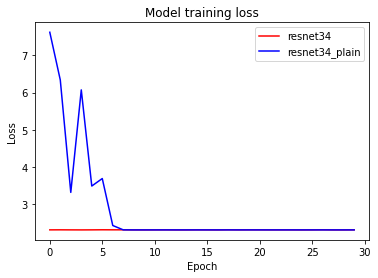

In [17]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['val_loss'], 'r')
plt.plot(history_34_plain.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet34_plain'], loc='upper right')
plt.show()

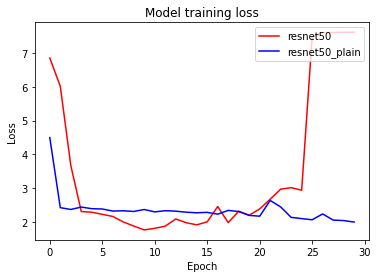

In [18]:
import matplotlib.pyplot as plt

plt.plot(history_50.history['val_loss'], 'r')
plt.plot(history_50_plain.history['val_loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'resnet50_plain'], loc='upper right')
plt.show()

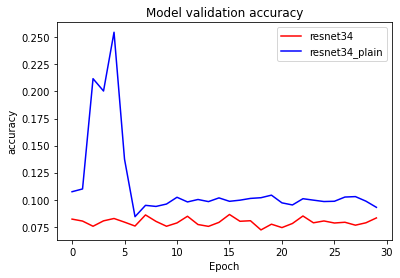

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_34.history['val_accuracy'], 'r')
plt.plot(history_34_plain.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet34', 'resnet34_plain'], loc='upper right')
plt.show()

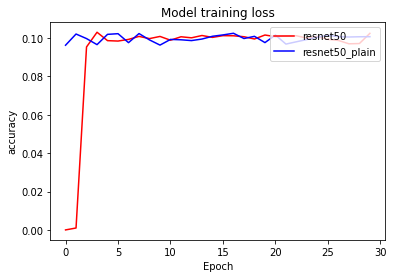

In [21]:
import matplotlib.pyplot as plt

plt.plot(history_50.history['val_accuracy'], 'r')
plt.plot(history_50_plain.history['val_accuracy'], 'b')
plt.title('Model training loss')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet50', 'resnet50_plain'], loc='upper right')
plt.show()

# 회고


resnet34에서 output shape이 multiple이 나오는 것은 버전이 바뀌면서 해결되었다고 한다.